In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import TpotAutoml
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
# user inputs:
RS = 13
np.random.seed(RS)
KEEP_ROWS_FRAC = 0.05 # set to 1 if all rows are meant to be kept
skiprows_func = lambda i: i>0 and np.random.rand() > KEEP_ROWS_FRAC

In [3]:
usecols=['item_id', 'activation_date', 'city', 'region',
                              'parent_category_name', 'category_name', 
                             'item_seq_number', 'user_type', 'price_norm']

In [4]:
all_samples = pd.read_csv('data/all_samples_no_nulls.csv', usecols=usecols, skiprows=skiprows_func)

In [5]:
train = pd.read_csv('data/train.csv', usecols=['item_id', 'activation_date', 'deal_probability'])

In [6]:
all_samples.head()

,item_id,region,city,parent_category_name,category_name,item_seq_number,activation_date,user_type,price_norm
0,d5480bb4a6e4,Ханты-Мансийский АО,Ханты-Мансийск,Недвижимость,Квартиры,6.0,2017-03-25,Private,-0.793391
1,071e1ed13c5c,Омская область,Москаленки,Личные вещи,"Одежда, обувь, аксессуары",4.0,2017-03-24,Private,0.069591
2,065a4daba35f,Нижегородская область,Нижний Новгород,Животные,Товары для животных,310.0,2017-03-16,Company,0.000000
3,71d9399b59a2,Саратовская область,Саратов,Личные вещи,"Одежда, обувь, аксессуары",12.0,2017-03-25,Private,0.069591
4,f5259a31c938,Владимирская область,Владимир,Личные вещи,"Одежда, обувь, аксессуары",80.0,2017-03-24,Company,0.654802


In [7]:
train = train.merge(all_samples, how='left', on=['item_id', 'activation_date'])

In [8]:
train = train.dropna()

In [9]:
train = train.sort_values(by='activation_date').drop('activation_date', axis=1).set_index('item_id')

In [10]:
train = pd.get_dummies(train)

In [11]:
target = 'deal_probability'
TIMEOUT_MINS = None
SCORING = 'r2'
RS=27
X = (train.drop(target, axis=1)).values
y = train[target].values
tss = TimeSeriesSplit(n_splits=4)
train_index, test_index = list(tss.split(X))[-1]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

config_dict = {'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100, 200, 400],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },
        'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100, 200, 400],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },
              }

tpot = TpotAutoml(mode='regression',
                  max_time_mins=TIMEOUT_MINS,
                  generations = 1, population_size=1,
                  scoring=SCORING,
                  random_state=RS,
                  n_jobs=1,
                  verbosity=2,
                  cv=TimeSeriesSplit(n_splits=3),
                  config_dict=config_dict,                 
                 )

In [12]:
# base_model = GradientBoostingRegressor()
base_model = RandomForestRegressor()
tpot = RandomizedSearchCV(estimator=base_model, random_state=RS,
#                           param_distributions=config_dict['sklearn.ensemble.GradientBoostingRegressor'],
                          param_distributions=config_dict['sklearn.ensemble.RandomForestRegressor'],
                         n_iter=15,
                         scoring='r2',
                         cv=TimeSeriesSplit(n_splits=4),
                         verbose=2,
                         n_jobs=4)

In [13]:
tpot.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=11, max_features=0.25, bootstrap=True 
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=11, max_features=0.25, bootstrap=True 
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=11, max_features=0.25, bootstrap=True 
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=11, max_features=0.25, bootstrap=True 
[CV] n_estimators=400, min_samples_split=11, min_samples_leaf=4, max_features=0.6500000000000001, bootstrap=False 
[CV] n_estimators=400, min_samples_split=11, min_samples_leaf=4, max_features=0.6500000000000001, bootstrap=False 
[CV] n_estimators=400, min_samples_split=11, min_samples_leaf=4, max_features=0.6500000000000001, bootstrap=False 
[CV] n_estimators=400, min_samples_split=11, min_samples_leaf=4, max_features=0.6500000000000001, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=11, max_features=

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 90.9min


[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=10, max_features=0.9500000000000001, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=10, max_features=0.6500000000000001, bootstrap=False, total=16.9min
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=10, max_features=0.9500000000000001, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=19, min_samples_leaf=19, max_features=0.7000000000000001, bootstrap=True, total=26.8min
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=10, max_features=0.9500000000000001, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=11, min_samples_leaf=4, max_features=0.6500000000000001, bootstrap=False, total=106.3min
[CV] n_estimators=400, min_samples_split=20, min_samples_leaf=10, max_features=0.9500000000000001, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=10, max_features=0.6500000000000001, bootstrap=False, total=29.7min
[CV] n_estimato

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 306.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=15, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 400], 'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21), 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=27, refit=True,
          return_train_score='warn', scoring='r2', verbo

In [14]:
feat_importance_entropy = list(zip(train.drop(target, axis=1).columns.values, tpot.best_estimator_.feature_importances_))

In [19]:
sorted(list(feat_importance_entropy), key=lambda x:x[1], reverse=True)[:10]

[('parent_category_name_Личные вещи', 0.12835782441363583),
 ('price_norm', 0.11902642762016383),
 ('parent_category_name_Услуги', 0.10318757189515386),
 ('category_name_Предложение услуг', 0.10120484703812113),
 ('item_seq_number', 0.08581687134049139),
 ('category_name_Одежда, обувь, аксессуары', 0.0643807481694361),
 ('category_name_Детская одежда и обувь', 0.05015162931894308),
 ('category_name_Товары для детей и игрушки', 0.04185459160413521),
 ('category_name_Автомобили', 0.022401364926905185),
 ('parent_category_name_Транспорт', 0.021698789049190138)]

In [16]:
test_score = tpot.score(X_test, y_test)
print(test_score)

0.15932087617227075


In [17]:
rmse = np.sqrt(np.mean((tpot.predict(X_test) - y_test) ** 2))
rmse

0.2373720652311736

0.1416121326420318
0.1374720400801603


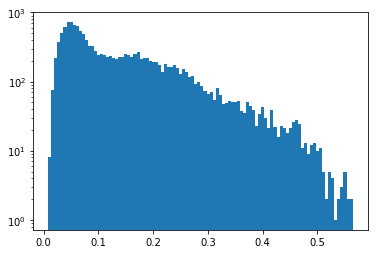

In [21]:
plt.hist(tpot.predict(X_test), log=True, bins=100)
print(tpot.predict(X_test).mean())
print(y_test.mean())

In [25]:
from analysis import Analysis
ea = Analysis(tpot, X_train, y_train, X_test, y_test,
                           mode='regression', target=target,
                           features=train.drop(target, axis=1).columns,
                           test_samples_index=test_index, random_state=RS)

In [ ]:
ea.get_feature_importance(sort=True)

In [ ]:
tpot.best_estimator_

In [ ]:
test = pd.read_csv('data/test.csv', usecols=['item_id', 'activation_date'])
len(test)

In [ ]:
test = test.merge(all_samples, how='left', on=['item_id', 'activation_date'])
len(test)

In [ ]:
test = test.set_index('item_id')

In [ ]:
test['deal_probability'] = tpot.predict(test.values)

In [ ]:
import pickle
# pickle.dump(tpot, open('predictions/gbr_tabular_randomized_searched.pickle', 'wb'))
# model = pickle.load(open('predictions/gbr_tabular_randomized_searched.pickle', 'rb'))

In [ ]:
test_score = model.score(X_test, y_test)
print(test_score)